In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from mst_prim import prim_mst
from nemo import evaluate_nemo
import util
from util import lighten_color
from util import centroid_label, coordinator_label, worker_label, ccolor, cmarker
from topology import get_lognorm_hist, setup_topology, get_lognorm_samples
import topology

plt.rcParams.update({'font.size': 12})

#### Topology Setup

In [2]:
seed = 10
np.random.seed(seed)

device_number = 1000 + 1
avg = 50
c_capacity = 50
max_resources = device_number * avg - c_capacity

X_dim_range = [0, 100]
Y_dim_range = [-50, 50]
centers = 40

H, bins = get_lognorm_hist()
coords_df = topology.coords_sim(1000, centers, X_dim_range, Y_dim_range, seed)

coord_dict = {}
coord_dict = topology.get_coords_dict() # uncomment for the other topologies
coord_dict["sim(1000)"] = coords_df
df_dict_topologies = topology.create_topologies_from_dict(coord_dict, H, max_resources, c_capacity,
                                                          weights=(1, avg * 2), dist="lognorm", with_clustering=True,
                                                          kmin=2, kmax=30, kseed=seed)

Creating df for planetlab
Optimal k is 3
Creating df for king
Optimal k is 5
Creating df for fit
Optimal k is 3
Creating df for atlas
Optimal k is 6
Creating df for sim(1000)
Optimal k is 8
Done


In [3]:
t_label = "sim(1000)"
prim_df, c_coords, base_col, slot_columns, centroids, opt_k, sil = df_dict_topologies[t_label]
coords = prim_df[["x", "y"]].to_numpy()
prim_df["weight_1"] = 1
prim_df["weight_2"] = 2

eval_matrix = {}
prim_df

,x,y,latency,type,base,weight,capacity_100,capacity_90,capacity_80,capacity_70,...,capacity_50,capacity_40,capacity_30,capacity_20,capacity_10,capacity_5,capacity_1,cluster,weight_1,weight_2
0,19.383905,7.406120,0.000000,coordinator,1002001,0,50,50,50,50,...,50,50,50,50,50,50,50,-1,1,2
1,67.743232,-14.007158,52.888118,worker,1002001,5,50,51,55,48,...,46,33,54,34,21,144,18,2,1,2
2,5.220579,-15.467092,26.903228,worker,1002001,8,50,48,47,49,...,54,68,36,34,88,19,15,4,1,2
3,43.521014,41.129903,41.471599,worker,1002001,1,50,50,53,45,...,65,39,73,52,54,19,4,1,1,2
4,14.195029,1.412734,7.927491,worker,1002001,38,50,53,47,44,...,42,60,35,47,42,11,4,5,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,14.908514,-3.352142,11.652010,worker,1002001,2,50,53,46,51,...,58,42,74,113,65,29,102,5,1,2
997,39.672067,34.499402,33.847532,worker,1002001,4,50,51,51,52,...,37,35,34,41,52,81,0,1,1,2
998,40.609309,23.985392,26.933066,worker,1002001,1,50,49,47,50,...,48,37,46,78,57,32,8,1,1,2
999,31.878351,34.859971,30.163307,worker,1002001,8,50,49,52,44,...,37,79,57,34,33,16,18,1,1,2


In [4]:
print("Required:", prim_df["weight"].sum(), "Available:", prim_df["capacity_100"].sum())

Required: 6615 Available: 50050


In [5]:
colors, light_colors, palette = util.get_color_list(opt_k)
palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)]

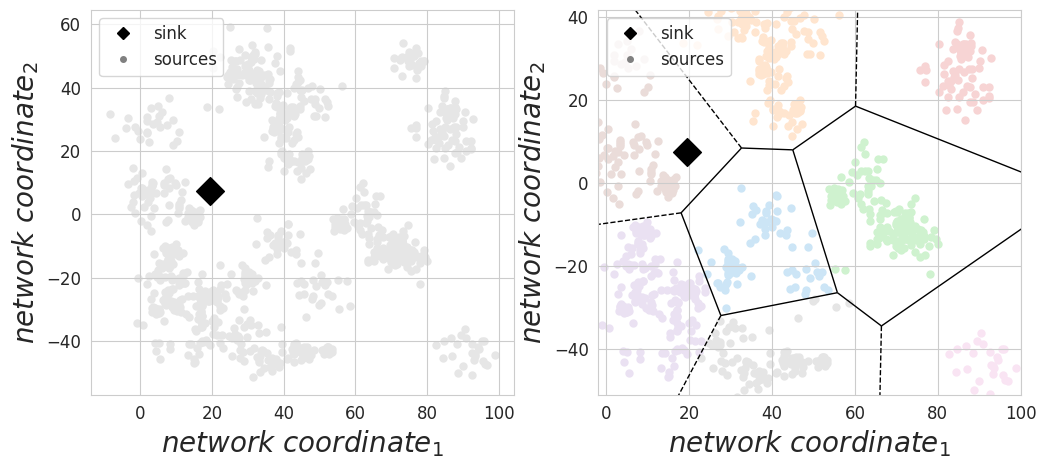

In [6]:
X_dim_def = [-50, 50]
Y_dim_def = [-60, 60]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
util.plot_topology(ax1, prim_df)
util.plot_topology(ax2, prim_df, colors, 'Topology (k=' + str(opt_k) + ")")

#ax1.set_xlim(X_dim_def)
#ax2.set_xlim(X_dim_def)

#ax1.set_ylim(Y_dim_def)
#ax2.set_ylim(Y_dim_def)

X_dim = ax1.get_xlim()
Y_dim = ax1.get_ylim()

plt.show()

### Experiment 2b: NEMO Aggregation with Density-based Grouping

In [124]:
# fixed params
max_levels = 50
slot_col = "capacity_100"
weight_col = "weight_1"

# dynamic params
num_points = 9
mu_start = 0.1
end = 0.9
hyperparam_values_1 = np.linspace(mu_start, end, num_points)
hyperparam_values_2 = np.linspace(mu_start, end, num_points)
X, Y = np.meshgrid(hyperparam_values_1, hyperparam_values_2)

# Initialize an array to store performance values
perc_lat_values = np.zeros_like(X)
mean_lat_values = np.zeros_like(X)

for i in range(num_points):
    for j in range(num_points):
        eval_dict, df_dict, opt_dict, limits_dict = evaluate_nemo(prim_df, [slot_col], weight_col, merge_factor=X[i, j], step_size=Y[i, j], max_levels=max_levels, with_eval=True)
        sv = eval_dict[slot_col]["latency_distribution"].sort_values()
        perc_lat = round(sv.quantile(0.9), 2)
        mean_lat = round(sv.mean(), 2)
        print(perc_lat, mean_lat)

        perc_lat_values[i, j] = perc_lat
        mean_lat_values[i, j] = mean_lat

Starting nemo for: c=capacity_100, w=weight_1, l=50, step_size=0.1, merge_factor=0.1
Level 0 CH number:  1000
--------Balancing load for 14 clusters to 0
Clusters processed: 0
Clusters processed: 10
Level 1 CH number:  31
Evaluating for capacity_100
94.88 63.27
Starting nemo for: c=capacity_100, w=weight_1, l=50, step_size=0.1, merge_factor=0.2
Level 0 CH number:  1000
--------Balancing load for 14 clusters to 0
Clusters processed: 0
Clusters processed: 10
Level 1 CH number:  31
Evaluating for capacity_100
94.88 63.27
Starting nemo for: c=capacity_100, w=weight_1, l=50, step_size=0.1, merge_factor=0.30000000000000004
Level 0 CH number:  1000
--------Balancing load for 14 clusters to 0
Clusters processed: 0
Clusters processed: 10
Level 1 CH number:  31
Evaluating for capacity_100
94.88 63.27
Starting nemo for: c=capacity_100, w=weight_1, l=50, step_size=0.1, merge_factor=0.4
Level 0 CH number:  1000
--------Balancing load for 14 clusters to 0
Clusters processed: 0
Clusters processed: 10

KeyboardInterrupt: 

merge factor and step size for minimum latency (90P): (X=0.1, Y=0.4) 0.0
merge factor and step size for minimum latency (mean): (X=0.1, Y=0.4) 0.0


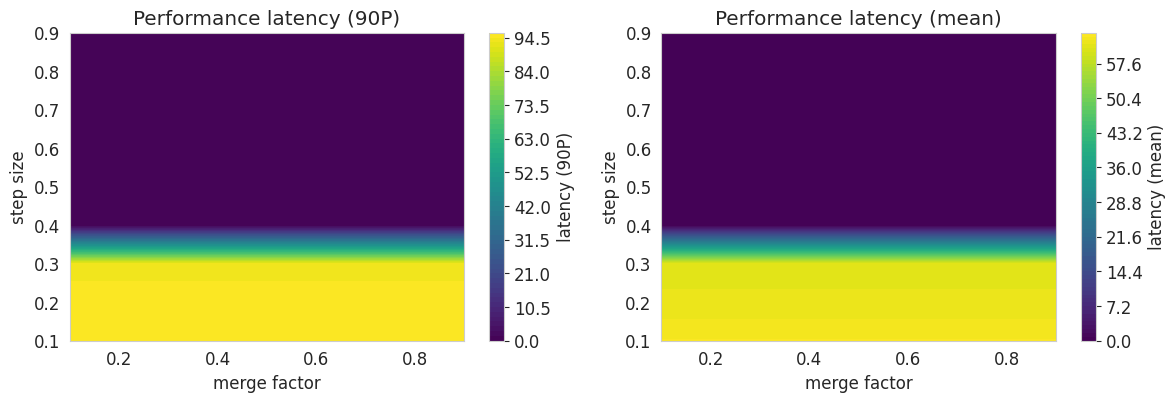

In [125]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

for i, values in enumerate([perc_lat_values, mean_lat_values]):
    if i == 0:
        label = "latency (90P)"
    elif i == 1:
        label = "latency (mean)"
    else:
        label = "undefined"
        
    # Find the indices of the minimum Z value
    min_index = np.unravel_index(np.argmin(values), values.shape)
    # Use the indices to get the corresponding X and Y values
    min_X = X[min_index]
    min_Y = Y[min_index]
    print(f"merge factor and step size for minimum {label}: (X={min_X}, Y={min_Y})", values[min_index])
    
    # Create a contour plot
    ax = axs[i]
    contour = ax.contourf(X, Y, values, levels=80, cmap='viridis')

    # Create a colorbar and set the label
    colorbar = plt.colorbar(contour)
    colorbar.set_label(label)
    
    ax.set_title(f"Performance {label}")
    ax.set_xlabel('merge factor')
    ax.set_ylabel('step size')
    
plt.show()

In [137]:
# assign nodes to previous clustering alg
max_levels = 50
merge_factor = 0.4 # weight_1 0.4, weight 0.9
step_size = 0.2 # weight_1 0.2, weight 0.3

slot_col = "capacity_100"
weight_col = "weight"
eval_name = "nemo" + "_" + weight_col

df_dict_1, opt_dict_1, limits_dict_1 = evaluate_nemo(prim_df, [slot_col], weight_col, step_size=step_size, merge_factor=merge_factor, max_levels=1, with_eval=False)
eval_matrix[eval_name], df_dict, opt_dict, limits_dict = evaluate_nemo(prim_df, [slot_col], weight_col, step_size=step_size, merge_factor=merge_factor, max_levels=max_levels, with_eval=True)

Starting nemo for: c=capacity_100, w=weight, l=1, step_size=0.2, merge_factor=0.4
Level 0 CH number:  1000
--------Balancing load for 14 clusters to 0
Clusters processed: 0
Clusters processed: 10
Level 1 CH number:  144
final assignment ------------------Load reached 0 -939
Starting nemo for: c=capacity_100, w=weight, l=50, step_size=0.2, merge_factor=0.4
Level 0 CH number:  1000
--------Balancing load for 14 clusters to 0
Clusters processed: 0
Clusters processed: 10
Level 1 CH number:  144
final assignment ------------------Load reached 0 -939
Evaluating for capacity_100


In [138]:
eval_matrix.keys()

dict_keys(['nemo_weight_1', 'nemo_weight'])

In [139]:
df = df_dict[slot_col]
df

,oindex,x,y,type,cluster,total_weight,unbalanced_weight,used_weight,total_capacity,free_capacity,level,parent,load
0,0,16.663910,-28.285326,coordinator,-1,<NA>,<NA>,<NA>,50,-939,2,<NA>,989
1,1,15.312847,-24.942200,worker,5,4,0,4,50,50,0,353,0
2,2,11.239266,43.820651,worker,10,37,0,17,50,50,0,471,0
3,2,11.239266,43.820651,worker,10,37,0,20,50,50,0,532,0
4,3,9.823663,47.669200,worker,10,1,0,1,50,50,0,906,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,998,92.008305,41.694022,worker,1,36,0,26,50,50,0,706,0
1042,998,92.008305,41.694022,worker,1,36,0,10,50,50,0,206,0
1043,999,86.110828,46.566577,worker,1,2,0,2,50,50,0,206,0
1044,1000,86.509504,50.253034,worker,1,33,0,19,50,50,0,292,0


In [140]:
df[df["parent"] == df["oindex"]]

,oindex,x,y,type,cluster,total_weight,unbalanced_weight,used_weight,total_capacity,free_capacity,level,parent,load


In [141]:
df[df["parent"] == 0]

,oindex,x,y,type,cluster,total_weight,unbalanced_weight,used_weight,total_capacity,free_capacity,level,parent,load
19,18,54.943575,-13.994417,worker,9,3,0,3,50,10,1,0,40
25,24,85.575771,16.502590,worker,6,1,0,1,50,8,1,0,42
53,48,76.876852,-25.629032,worker,4,1,0,1,50,1,1,0,49
63,58,61.409648,13.098452,worker,11,6,0,6,50,29,1,0,21
68,62,34.373546,10.708549,worker,7,4,0,4,50,23,1,0,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...
986,944,39.495351,28.568906,worker,7,14,0,14,50,0,1,0,50
996,954,13.711501,31.034940,worker,0,1,0,1,50,0,1,0,50
999,957,75.334748,-25.541756,worker,4,3,0,3,50,0,1,0,50
1003,961,16.891157,15.621646,worker,0,10,0,10,50,0,1,0,50


In [142]:
# check -> should be empty
df_overloaded = df.groupby(['parent'])['used_weight'].sum().copy().reset_index()
df_join = df[["oindex", "total_capacity", "free_capacity"]]
result = pd.merge(df_join, df_overloaded, left_on='oindex', right_on='parent', how='inner')
result["delta"] = result["total_capacity"] - result["used_weight"]
result[result["delta"] < 0]

,oindex,total_capacity,free_capacity,parent,used_weight,delta
0,0,50,-939,0,989,-939


In [143]:
# check -> should be empty
result[result["delta"] != result["free_capacity"]]

,oindex,total_capacity,free_capacity,parent,used_weight,delta


In [144]:
result

,oindex,total_capacity,free_capacity,parent,used_weight,delta
0,0,50,-939,0,989,-939
1,18,50,10,18,40,10
2,24,50,8,24,42,8
3,48,50,1,48,49,1
4,58,50,29,58,21,29
...,...,...,...,...,...,...
130,944,50,0,944,50,0
131,954,50,0,954,50,0
132,957,50,0,957,50,0
133,961,50,0,961,50,0


In [145]:
#create greedy aggregation tree
cluster_coords = centroids
cluster_coords_with_crd = np.column_stack((c_coords, cluster_coords.T)).T

mst = prim_mst(cluster_coords_with_crd)

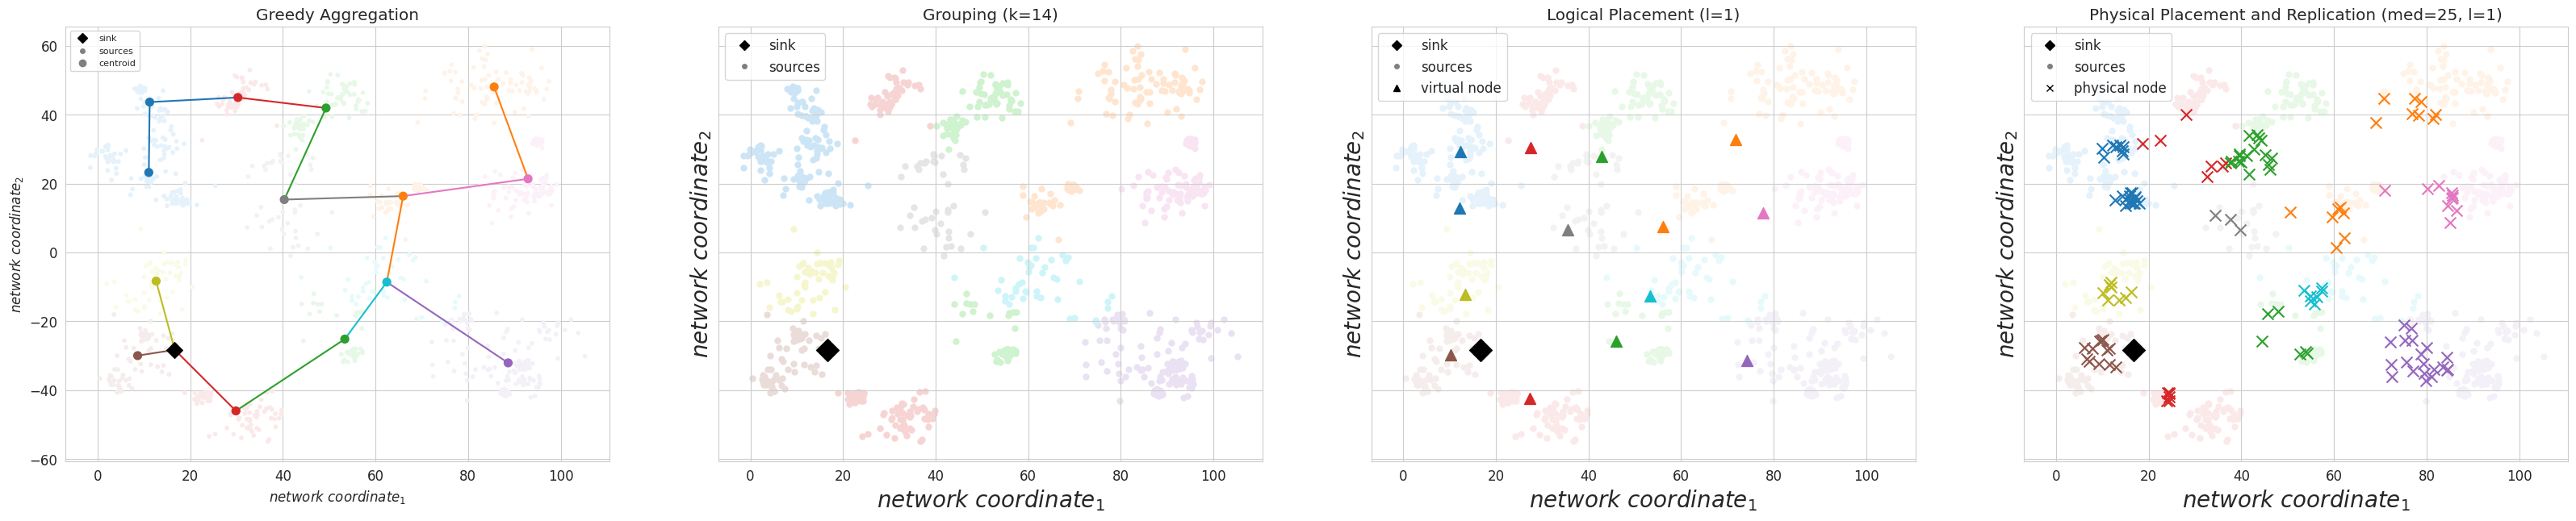

In [146]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(40, 7), sharex="all", sharey="all")
lval = 0.1
labels = prim_df["cluster"]

# plot greedy approach from MST
for i in range(1, len(mst)):
    point1 = cluster_coords_with_crd[i]
    point2 = cluster_coords_with_crd[mst[i]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    ax1.plot(x_values, y_values, zorder=2, color=colors[i - 1])

ax1.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=10)
ax1.scatter(cluster_coords[:, 0], cluster_coords[:, 1], s=50, color=colors[:len(cluster_coords)], zorder=3)
# in case all coords shall be plotted
ax1.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, lval) for x in colors[labels]])

lcentroid = Line2D([], [], color="blue", marker='o', linestyle='None', label='centroid')
ax1.legend(handles=[coordinator_label, worker_label, centroid_label], loc="upper left", bbox_to_anchor=(0, 1),
           fontsize=8)

ax1.set_xlabel('$network$ $coordinate_1$')
ax1.set_ylabel('$network$ $coordinate_2$')
ax1.set_title('Greedy Aggregation')

#plot grouping
util.plot_topology(ax2, prim_df, colors, title='Grouping (k=' + str(opt_k) + ")")

#plot logical nodes (optima) of different groups
# util.plot2(ax3, prim_df, df_dict[slot_col], colors, lval=lval, show_centroids=True)
util.plot_optimum(ax3, prim_df, opt_dict_1[slot_col], colors, lval=lval, plot_centroid=False, plot_lines=False)

# plot physical nodes
util.plot(ax4, prim_df, df_dict_1[slot_col], colors, lval=lval, plot_centroids=False, plot_lines=False)

#plt.xlim(X_dim)
#plt.ylim(Y_dim)
ax3.set_title("Logical Placement (l=1)")
ax4.set_title("Physical Placement and Replication (med=" + str(25) + ", l=1)")

#plt.savefig("plots/sim_1000/nemo_phases.svg", bbox_inches="tight")
plt.show()

Starting nemo for: c=capacity_100, w=weight, l=1, step_size=0.2, merge_factor=0.4
Level 0 CH number:  1000 Load: 6240
--------Balancing load for 14 clusters to 0
Clusters processed: 0
Clusters processed: 10
Level 1 CH number:  144 Load: 989
final assignment ------------------Load reached 0 -939
Starting nemo for: c=capacity_100, w=weight, l=2, step_size=0.2, merge_factor=0.4
Level 0 CH number:  1000 Load: 6240
--------Balancing load for 14 clusters to 0
Clusters processed: 0
Clusters processed: 10
Level 1 CH number:  144 Load: 989
--------Balancing load for 5 clusters to 0
Clusters processed: 0
Level 2 CH number:  25 Load: 132
final assignment ------------------Load reached 0 -82
Starting nemo for: c=capacity_100, w=weight, l=5, step_size=0.2, merge_factor=0.4
Level 0 CH number:  1000 Load: 6240
--------Balancing load for 14 clusters to 0
Clusters processed: 0
Clusters processed: 10
Level 1 CH number:  144 Load: 989
--------Balancing load for 5 clusters to 0
Clusters processed: 0
Level

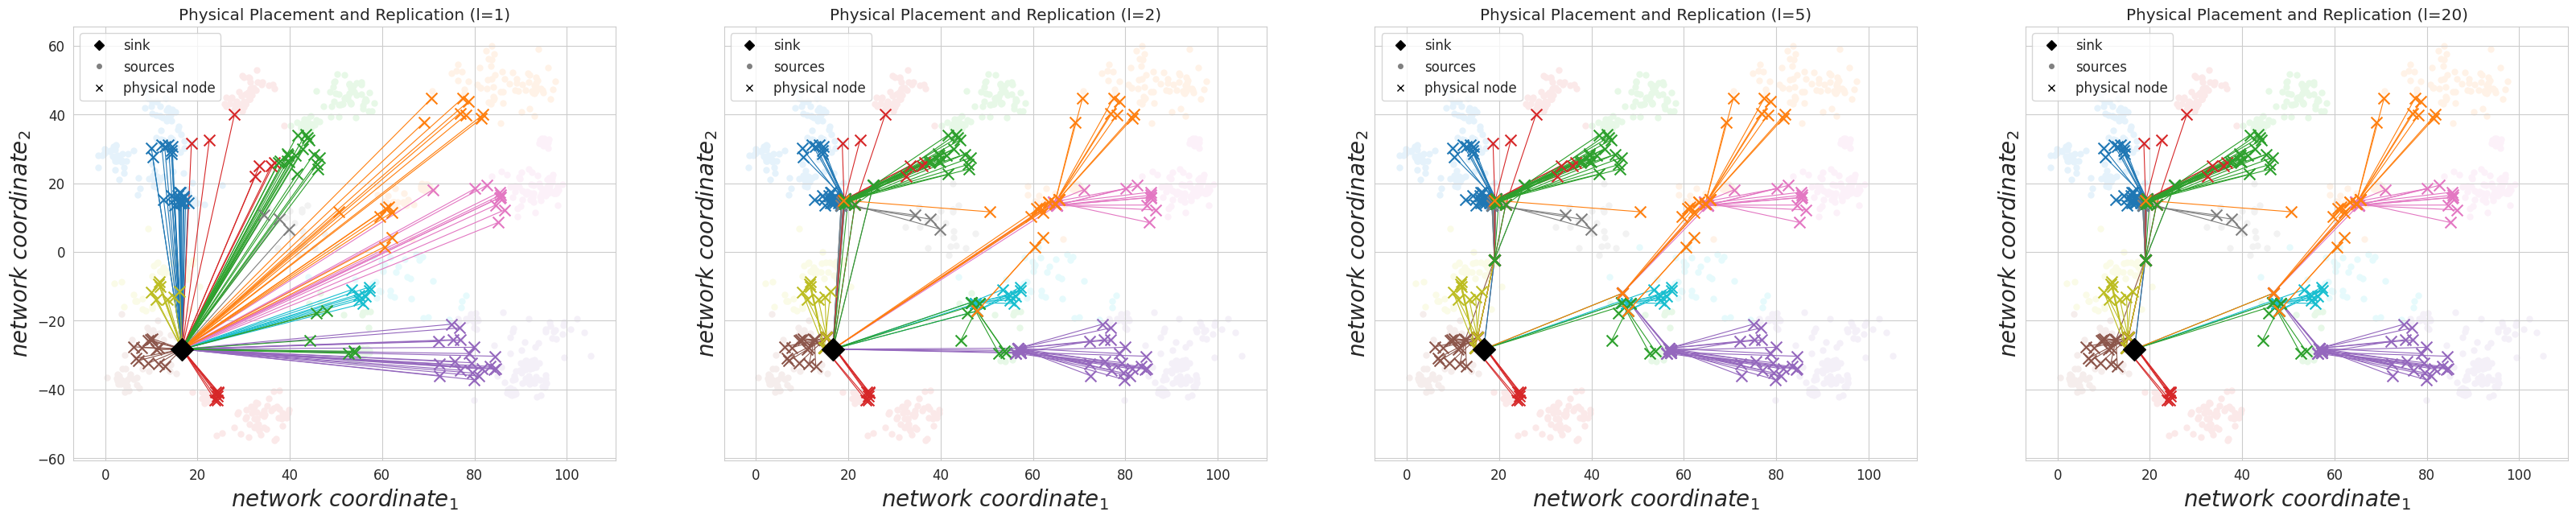

In [148]:
levels = [1, 2, 5, 20]

fig, axs = plt.subplots(1, 4, figsize=(40, 7), sharex="all", sharey="all")
lval = 0.1

for i, level in enumerate(levels):
    df_dict_i, opt_dict_i, limits_dict_i = evaluate_nemo(prim_df, [slot_col], weight_col, step_size=step_size, merge_factor=merge_factor, max_levels=level, with_eval=False)
    util.plot(axs[i], prim_df, df_dict_i[slot_col], colors, lval=lval, plot_centroids=False, plot_lines=True)
    axs[i].set_title("Physical Placement and Replication (l=" + str(level) + ")")

plt.show()

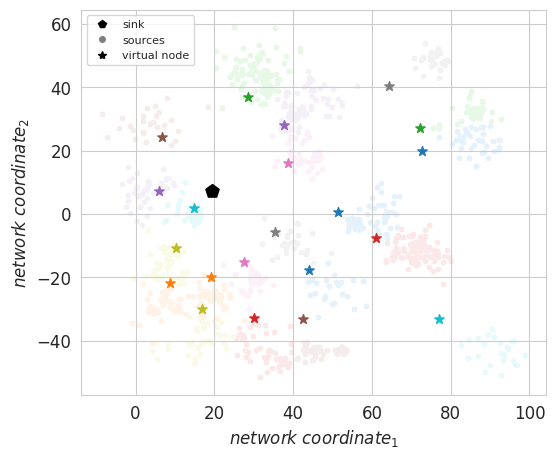

In [41]:
fig = plt.figure(figsize=(6, 5)).gca()

#uncomment this to plot nemo grouping
#ax2.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, 0.2) for x in colors[labels]], zorder=-1)
#ax2.scatter(cluster_coords[:, 0], cluster_coords[:, 1], s=50, color=colors[:no_clusters], zorder=2)
#ax2.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=1)
#ax2.set_title('Grouping (k=' + str(opt_k) + ")")
#fig.legend(handles=[coordinator_label, worker_label, centroid_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)

#uncomment this for nemo placement
util.plot_optimum(fig, prim_df, opt_dict[slot_col], colors, lval=lval, plot_centroid=False, plot_lines=False)

#uncomment this for nemo redistribution
#util.plot(fig, new_paths_flat[slot_col], agg_dict_flat[slot_col], c_coords, cluster_coords, coords, colors, labels, changed_labels=reassigned_clussters, lval=lval)


fig.set_xlabel('$network$ $coordinate_1$')
fig.set_ylabel('$network$ $coordinate_2$')

#plt.savefig("plots/sim_1000/nemo_placement.svg", bbox_inches="tight")
plt.show()

## Evaluation

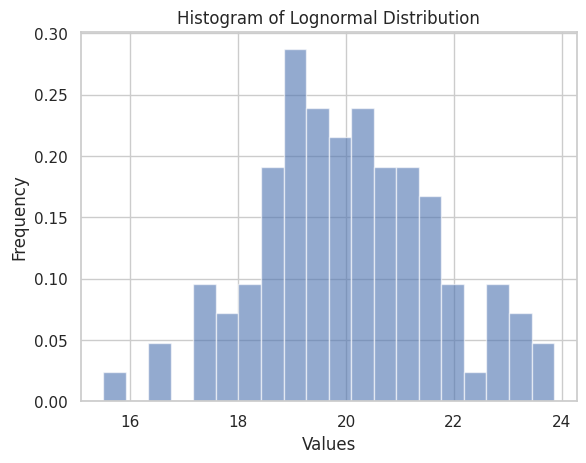

In [157]:
# Set the parameters
mean = 3.0  # Mean of the lognormal distribution
sigma = 0.1  # Standard deviation of the lognormal distribution
length = 100  # Desired length of the list

# Generate random values from a lognormal distribution
random_values = np.random.lognormal(mean, sigma, length)

# Plot a histogram of the random values
plt.hist(random_values, bins=20, density=True, alpha=0.6, color='b')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Lognormal Distribution')
plt.grid(True)

# Show the plot
plt.show()

### Capacity Limit Test

In [7]:
param_dict = {
    "sim(1000)": {"merge_factor": 0.2, "step_size": 0.2},
    "fit": {"merge_factor": 0.2, "step_size": 0.2},
    "planetlab": {"merge_factor": 0.2, "step_size": 0.2},
    "king": {"merge_factor": 0.3, "step_size": 0.2},
    "atlas": {"merge_factor": 0.2, "step_size": 0.1}
}

In [8]:
mu_start = 0.0
mu_stop = 100
mu_step = .2
values_topo = {}
slot_col = "capacity_100"

for t_label in df_dict_topologies.keys():
    print("Starting for topology", t_label)
    df, c_coords, base_col, slot_columns, centroids, opt_k, sil = df_dict_topologies[t_label]
    values = {}
    size = df.shape[0]
    current_mu = mu_start
    while current_mu < mu_stop:
        print(current_mu)
        out = get_lognorm_samples(1, avg * 2, size, mu=current_mu, sigma=1)
        df["weight"] = out
        df_dict, opt_dict, limits_dict = evaluate_nemo(df, [slot_col], "weight", step_size=param_dict[t_label]["step_size"], merge_factor=param_dict[t_label]["merge_factor"], with_eval=False)
        if limits_dict[slot_col]:
            break
        
        levels = df_dict[slot_col].loc[0, "level"]
        cluster_heads = df_dict[slot_col]["parent"].nunique()
        ch_rel = cluster_heads / size
        values[current_mu] = (np.mean(out), np.median(out), np.max(out), levels, cluster_heads, ch_rel)
        current_mu += mu_step

    values_topo[t_label] = values

print("Done")

Starting for topology planetlab
0.0
Starting nemo for: c=capacity_100, w=weight, l=20, step_size=0.2, merge_factor=0.2
Level 0 CH number:  468 Load: 857
--------Balancing load for 3 clusters to 0
Level 1 CH number:  10 Load: 18
0.2
Starting nemo for: c=capacity_100, w=weight, l=20, step_size=0.2, merge_factor=0.2
Level 0 CH number:  468 Load: 1011
--------Balancing load for 3 clusters to 0
Level 1 CH number:  11 Load: 45
0.4
Starting nemo for: c=capacity_100, w=weight, l=20, step_size=0.2, merge_factor=0.2
Level 0 CH number:  468 Load: 1162
--------Balancing load for 3 clusters to 0
Level 1 CH number:  12 Load: 26
0.6000000000000001
Starting nemo for: c=capacity_100, w=weight, l=20, step_size=0.2, merge_factor=0.2
Level 0 CH number:  468 Load: 1401
--------Balancing load for 3 clusters to 0
Level 1 CH number:  15 Load: 29
0.8
Starting nemo for: c=capacity_100, w=weight, l=20, step_size=0.2, merge_factor=0.2
Level 0 CH number:  468 Load: 1853
--------Balancing load for 3 clusters to 0
L

In [9]:
plot_topo = {
    "sim(1000)": {"color": "blue", "marker": "s"},
    "fit": {"color": "purple", "marker": "D"},
    "planetlab": {"color": "gold", "marker": "v"},
    "king": {"color": "teal", "marker": "p"},
    "atlas": {"color": "brown", "marker": "x"}
}

In [10]:
values_topo.keys()

dict_keys(['planetlab', 'king', 'fit', 'atlas', 'sim(1000)'])

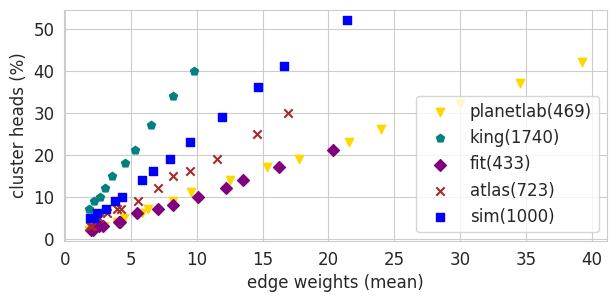

In [14]:
# Specify the figure size (e.g., 8x6 inches)
fig, ax = plt.subplots(figsize=(7, 3))

for k in values_topo.keys():
    data_dict = values_topo[k]
    
    # Extract the keys and values from the dictionary
    keys = list(data_dict.keys())
    x_values = [round(item[0], 2) for item in data_dict.values()]
    y_values = [round(item[5], 2) * 100 for item in data_dict.values()]
    
    c = plot_topo[k]["color"]
    m = plot_topo[k]["marker"]
    
    # Create the main plot
    if k != "sim(1000)":
        k = k + "(" + str(df_dict_topologies[k][0].shape[0]) + ")"
    ax.scatter(x_values, y_values, marker=m, color=c, label=k)
    
    # Calculate the regression line
    #coefficients = np.polyfit(x_values, y_values, 4)
    #regression_line = np.polyval(coefficients, x_values)
    
    # Plot the regression line
    #ax.plot(x_values, regression_line, "--", color=c)

# Add the vertical dashed line at x=8
#vertical_line_x = 8.5
#ax.axvline(x=vertical_line_x, color='r', linestyle='--')

# Add an annotation at the vertical line
#annotation_x = 8.7
#annotation_y = 320
#ax.annotate('resource \nlimit', xy=(vertical_line_x, annotation_y), xytext=(annotation_x, annotation_y),
#            arrowprops=dict(arrowstyle='->'))

# Add the horizontal dashed line at y=320
horizontal_line_y = 50
#ax.axhline(y=horizontal_line_y, color='red', linestyle='-.')

# Add an annotation at the horizontal line
annotation_x = 24  # X-coordinate of the annotation
annotation_y = 51  # Y-coordinate of the annotation
#ax.annotate('Capacity Limit', xy=(8, horizontal_line_y), xytext=(annotation_x, annotation_y),
#            arrowprops=dict(arrowstyle='->'))

# Set axis labels and title for the main plot
ax.set_xlabel('edge weights (mean)')
ax.set_ylabel('cluster heads (%)')

# ax.set_ylim([-1, 54])

# Create a legend for the scatter plot with a label
legend = ax.legend()
# legend.set_title("Topology")

plt.savefig("plots/weight_simulation.svg", bbox_inches="tight")

# Display the plot
plt.show()

### Hyperparameters Test

In [44]:
def get_opt_params(df, slot_col, weight_col, max_levels, start, end, num_points):
    out = {}
    
    # dynamic params
    hyperparam_values_1 = np.linspace(start, end, num_points)
    hyperparam_values_2 = np.linspace(start, end, num_points)
    X, Y = np.meshgrid(hyperparam_values_1, hyperparam_values_2)
    
    # Initialize an array to store performance values
    perc_lat_values = np.zeros_like(X)
    mean_lat_values = np.zeros_like(X)
    
    for i in range(num_points):
        for j in range(num_points):
            eval_dict, df_dict, opt_dict, limits_dict = evaluate_nemo(df, [slot_col], weight_col, merge_factor=X[i, j], step_size=Y[i, j], max_levels=max_levels, with_eval=True)
            
            if limits_dict[slot_col]:
                return {}, True
        
            sv = eval_dict[slot_col]["latency_distribution"].sort_values()
            perc_lat = round(sv.quantile(0.9), 2)
            mean_lat = round(sv.mean(), 2)
            print(perc_lat, mean_lat)
    
            perc_lat_values[i, j] = perc_lat
            mean_lat_values[i, j] = mean_lat
    
    for i, values in enumerate([perc_lat_values, mean_lat_values]):
        if i == 0:
            label = "latency (90P)"
        elif i == 1:
            label = "latency (mean)"
        else:
            label = "undefined"
            
        # Find the indices of the minimum Z value
        min_index = np.unravel_index(np.argmin(values), values.shape)
        # Use the indices to get the corresponding X and Y values
        min_X = X[min_index]
        min_Y = Y[min_index]
        print(f"merge factor and step size for minimum {label}: (X={min_X}, Y={min_Y})", values[min_index])
        out[label] = {"merge_factor": min_X, "step_size": min_Y}
    return out, False

In [132]:
df_dict_topologies.keys()

dict_keys(['planetlab', 'king', 'fit', 'atlas', 'sim(1000)'])

In [135]:
mu_start = 0.0
mu_stop = 100
mu_step = .4

pnum_points = 9
pstart = 0.1
pend = 0.9

slot_col = "capacity_100"
values_topo = {}

for t_label in ["atlas"]:
    print("Starting for topology", t_label)
    df, c_coords, base_col, slot_columns, centroids, opt_k, sil = df_dict_topologies[t_label]
    values = {}
    size = df.shape[0]
    current_mu = mu_start
    while current_mu < mu_stop:
        print(current_mu)
        out = get_lognorm_samples(1, avg * 2, size, mu=current_mu, sigma=1)
        df["weight"] = out
        params, stop = get_opt_params(df, slot_col, "weight", 50, pstart, pend, pnum_points)
        
        if stop:
            break
        
        values[current_mu] = {"mean": np.mean(out), "median": np.median(out), "params": params}
        current_mu += mu_step

    values_topo[t_label] = values

print(values_topo)
print("Done")

Starting for topology atlas
0.0
Starting nemo for: c=capacity_100, w=weight, l=50, step_size=0.1, merge_factor=0.1
Evaluating for capacity_100
415.81 310.96
Starting nemo for: c=capacity_100, w=weight, l=50, step_size=0.1, merge_factor=0.2
Evaluating for capacity_100
415.81 310.96
Starting nemo for: c=capacity_100, w=weight, l=50, step_size=0.1, merge_factor=0.30000000000000004
Evaluating for capacity_100
369.54 273.21
Starting nemo for: c=capacity_100, w=weight, l=50, step_size=0.1, merge_factor=0.4
Evaluating for capacity_100
369.54 273.21
Starting nemo for: c=capacity_100, w=weight, l=50, step_size=0.1, merge_factor=0.5
Evaluating for capacity_100
324.19 259.63
Starting nemo for: c=capacity_100, w=weight, l=50, step_size=0.1, merge_factor=0.6
Evaluating for capacity_100
290.92 249.08
Starting nemo for: c=capacity_100, w=weight, l=50, step_size=0.1, merge_factor=0.7000000000000001
Evaluating for capacity_100
290.92 249.08
Starting nemo for: c=capacity_100, w=weight, l=50, step_size=0

In [152]:
print(values_topo)

{'planetlab': {0.0: {'mean': 1.814498933901919, 'median': 1.0, 'params': {'latency (90P)': {'merge_factor': 0.1, 'step_size': 0.30000000000000004}, 'latency (mean)': {'merge_factor': 0.1, 'step_size': 0.8}}}, 0.4: {'mean': 2.55863539445629, 'median': 2.0, 'params': {'latency (90P)': {'merge_factor': 0.1, 'step_size': 0.30000000000000004}, 'latency (mean)': {'merge_factor': 0.1, 'step_size': 0.8}}}, 0.8: {'mean': 3.8507462686567164, 'median': 2.0, 'params': {'latency (90P)': {'merge_factor': 0.1, 'step_size': 0.30000000000000004}, 'latency (mean)': {'merge_factor': 0.1, 'step_size': 0.8}}}, 1.2000000000000002: {'mean': 5.71002132196162, 'median': 3.0, 'params': {'latency (90P)': {'merge_factor': 0.1, 'step_size': 0.4}, 'latency (mean)': {'merge_factor': 0.7000000000000001, 'step_size': 0.8}}}, 1.6: {'mean': 8.040511727078892, 'median': 5.0, 'params': {'latency (90P)': {'merge_factor': 0.7000000000000001, 'step_size': 0.4}, 'latency (mean)': {'merge_factor': 0.9, 'step_size': 0.6}}}, 2.0

In [162]:
values_topo = {'planetlab': {0.0: {'mean': 1.814498933901919, 'median': 1.0, 'params': {'latency (90P)': {'merge_factor': 0.1, 'step_size': 0.30000000000000004}, 'latency (mean)': {'merge_factor': 0.1, 'step_size': 0.8}}}, 0.4: {'mean': 2.55863539445629, 'median': 2.0, 'params': {'latency (90P)': {'merge_factor': 0.1, 'step_size': 0.30000000000000004}, 'latency (mean)': {'merge_factor': 0.1, 'step_size': 0.8}}}, 0.8: {'mean': 3.8507462686567164, 'median': 2.0, 'params': {'latency (90P)': {'merge_factor': 0.1, 'step_size': 0.30000000000000004}, 'latency (mean)': {'merge_factor': 0.1, 'step_size': 0.8}}}, 1.2000000000000002: {'mean': 5.71002132196162, 'median': 3.0, 'params': {'latency (90P)': {'merge_factor': 0.1, 'step_size': 0.4}, 'latency (mean)': {'merge_factor': 0.7000000000000001, 'step_size': 0.8}}}, 1.6: {'mean': 8.040511727078892, 'median': 5.0, 'params': {'latency (90P)': {'merge_factor': 0.7000000000000001, 'step_size': 0.4}, 'latency (mean)': {'merge_factor': 0.9, 'step_size': 0.6}}}, 2.0: {'mean': 11.643923240938166, 'median': 7.0, 'params': {'latency (90P)': {'merge_factor': 0.1, 'step_size': 0.4}, 'latency (mean)': {'merge_factor': 0.7000000000000001, 'step_size': 0.5}}}, 2.4: {'mean': 17.771855010660982, 'median': 11.0, 'params': {'latency (90P)': {'merge_factor': 0.7000000000000001, 'step_size': 0.4}, 'latency (mean)': {'merge_factor': 0.1, 'step_size': 0.7000000000000001}}}, 2.8: {'mean': 22.64179104477612, 'median': 14.0, 'params': {'latency (90P)': {'merge_factor': 0.7000000000000001, 'step_size': 0.4}, 'latency (mean)': {'merge_factor': 0.8, 'step_size': 0.6}}}, 3.1999999999999997: {'mean': 34.494669509594885, 'median': 24.0, 'params': {'latency (90P)': {'merge_factor': 0.1, 'step_size': 0.2}, 'latency (mean)': {'merge_factor': 0.1, 'step_size': 0.1}}}, 3.5999999999999996: {'mean': 44.53304904051173, 'median': 34.0, 'params': {'latency (90P)': {'merge_factor': 0.7000000000000001, 'step_size': 0.30000000000000004}, 'latency (mean)': {'merge_factor': 0.9, 'step_size': 0.2}}}}, 'king': {0.0: {'mean': 1.82816091954023, 'median': 1.0, 'params': {'latency (90P)': {'merge_factor': 0.9, 'step_size': 0.1}, 'latency (mean)': {'merge_factor': 0.9, 'step_size': 0.30000000000000004}}}, 0.4: {'mean': 2.731034482758621, 'median': 2.0, 'params': {'latency (90P)': {'merge_factor': 0.9, 'step_size': 0.1}, 'latency (mean)': {'merge_factor': 0.9, 'step_size': 0.30000000000000004}}}, 0.8: {'mean': 3.6206896551724137, 'median': 2.0, 'params': {'latency (90P)': {'merge_factor': 0.9, 'step_size': 0.1}, 'latency (mean)': {'merge_factor': 0.9, 'step_size': 0.1}}}, 1.2000000000000002: {'mean': 5.638505747126437, 'median': 3.0, 'params': {'latency (90P)': {'merge_factor': 0.9, 'step_size': 0.1}, 'latency (mean)': {'merge_factor': 0.9, 'step_size': 0.1}}}, 1.6: {'mean': 8.506896551724138, 'median': 5.0, 'params': {'latency (90P)': {'merge_factor': 0.9, 'step_size': 0.1}, 'latency (mean)': {'merge_factor': 0.9, 'step_size': 0.1}}}, 2.0: {'mean': 11.776436781609195, 'median': 7.0, 'params': {'latency (90P)': {'merge_factor': 0.7000000000000001, 'step_size': 0.1}, 'latency (mean)': {'merge_factor': 0.9, 'step_size': 0.4}}}}, 'fit': {0.0: {'mean': 1.926096997690531, 'median': 1.0, 'params': {'latency (90P)': {'merge_factor': 0.1, 'step_size': 0.7000000000000001}, 'latency (mean)': {'merge_factor': 0.1, 'step_size': 0.9}}}, 0.4: {'mean': 2.628175519630485, 'median': 1.0, 'params': {'latency (90P)': {'merge_factor': 0.1, 'step_size': 0.7000000000000001}, 'latency (mean)': {'merge_factor': 0.1, 'step_size': 0.9}}}, 0.8: {'mean': 3.5681293302540418, 'median': 2.0, 'params': {'latency (90P)': {'merge_factor': 0.1, 'step_size': 0.9}, 'latency (mean)': {'merge_factor': 0.1, 'step_size': 0.9}}}, 1.2000000000000002: {'mean': 5.833718244803695, 'median': 3.0, 'params': {'latency (90P)': {'merge_factor': 0.8, 'step_size': 0.6}, 'latency (mean)': {'merge_factor': 0.8, 'step_size': 0.6}}}, 1.6: {'mean': 8.2540415704388, 'median': 5.0, 'params': {'latency (90P)': {'merge_factor': 0.1, 'step_size': 0.5}, 'latency (mean)': {'merge_factor': 0.7000000000000001, 'step_size': 0.6}}}, 2.0: {'mean': 11.981524249422632, 'median': 7.0, 'params': {'latency (90P)': {'merge_factor': 0.1, 'step_size': 0.5}, 'latency (mean)': {'merge_factor': 0.7000000000000001, 'step_size': 0.5}}}, 2.4: {'mean': 17.224018475750576, 'median': 11.0, 'params': {'latency (90P)': {'merge_factor': 0.7000000000000001, 'step_size': 0.5}, 'latency (mean)': {'merge_factor': 0.7000000000000001, 'step_size': 0.5}}}, 2.8: {'mean': 25.0715935334873, 'median': 15.0, 'params': {'latency (90P)': {'merge_factor': 0.1, 'step_size': 0.2}, 'latency (mean)': {'merge_factor': 0.8, 'step_size': 0.4}}}, 3.1999999999999997: {'mean': 34.98614318706697, 'median': 26.0, 'params': {'latency (90P)': {'merge_factor': 0.9, 'step_size': 0.1}, 'latency (mean)': {'merge_factor': 0.9, 'step_size': 0.1}}}, 3.5999999999999996: {'mean': 41.5635103926097, 'median': 30.0, 'params': {'latency (90P)': {'merge_factor': 0.7000000000000001, 'step_size': 0.1}, 'latency (mean)': {'merge_factor': 0.7000000000000001, 'step_size': 0.1}}}}, 'sim(1000)': {0.0: {'mean': 1.9150849150849152, 'median': 1.0, 'params': {'latency (90P)': {'merge_factor': 0.6, 'step_size': 0.5}, 'latency (mean)': {'merge_factor': 0.9, 'step_size': 0.2}}}, 0.4: {'mean': 2.716283716283716, 'median': 2.0, 'params': {'latency (90P)': {'merge_factor': 0.8, 'step_size': 0.5}, 'latency (mean)': {'merge_factor': 0.9, 'step_size': 0.2}}}, 0.8: {'mean': 3.5554445554445553, 'median': 2.0, 'params': {'latency (90P)': {'merge_factor': 0.6, 'step_size': 0.4}, 'latency (mean)': {'merge_factor': 0.9, 'step_size': 0.4}}}, 1.2000000000000002: {'mean': 5.56043956043956, 'median': 3.0, 'params': {'latency (90P)': {'merge_factor': 0.9, 'step_size': 0.30000000000000004}, 'latency (mean)': {'merge_factor': 0.9, 'step_size': 0.2}}}, 1.6: {'mean': 8.534465534465534, 'median': 5.0, 'params': {'latency (90P)': {'merge_factor': 0.8, 'step_size': 0.30000000000000004}, 'latency (mean)': {'merge_factor': 0.8, 'step_size': 0.30000000000000004}}}, 2.0: {'mean': 11.444555444555444, 'median': 7.0, 'params': {'latency (90P)': {'merge_factor': 0.9, 'step_size': 0.1}, 'latency (mean)': {'merge_factor': 0.9, 'step_size': 0.1}}}, 2.4: {'mean': 17.43256743256743, 'median': 11.0, 'params': {'latency (90P)': {'merge_factor': 0.9, 'step_size': 0.2}, 'latency (mean)': {'merge_factor': 0.9, 'step_size': 0.2}}}}, 'atlas': {0.0: {'mean': 1.9861687413554634, 'median': 1.0, 'params': {'latency (90P)': {'merge_factor': 0.1, 'step_size': 0.8}, 'latency (mean)': {'merge_factor': 0.1, 'step_size': 0.8}}}, 0.4: {'mean': 2.5435684647302903, 'median': 2.0, 'params': {'latency (90P)': {'merge_factor': 0.9, 'step_size': 0.6}, 'latency (mean)': {'merge_factor': 0.9, 'step_size': 0.6}}}, 0.8: {'mean': 3.900414937759336, 'median': 2.0, 'params': {'latency (90P)': {'merge_factor': 0.9, 'step_size': 0.1}, 'latency (mean)': {'merge_factor': 0.9, 'step_size': 0.4}}}, 1.2000000000000002: {'mean': 5.2337482710926695, 'median': 3.0, 'params': {'latency (90P)': {'merge_factor': 0.9, 'step_size': 0.4}, 'latency (mean)': {'merge_factor': 0.9, 'step_size': 0.4}}}, 1.6: {'mean': 8.622406639004149, 'median': 5.0, 'params': {'latency (90P)': {'merge_factor': 0.8, 'step_size': 0.2}, 'latency (mean)': {'merge_factor': 0.1, 'step_size': 0.4}}}, 2.0: {'mean': 12.163208852005532, 'median': 8.0, 'params': {'latency (90P)': {'merge_factor': 0.8, 'step_size': 0.2}, 'latency (mean)': {'merge_factor': 0.7000000000000001, 'step_size': 0.4}}}, 2.4: {'mean': 18.32088520055325, 'median': 12.0, 'params': {'latency (90P)': {'merge_factor': 0.9, 'step_size': 0.1}, 'latency (mean)': {'merge_factor': 0.9, 'step_size': 0.1}}}, 2.8: {'mean': 24.910096818810512, 'median': 17.0, 'params': {'latency (90P)': {'merge_factor': 0.9, 'step_size': 0.30000000000000004}, 'latency (mean)': {'merge_factor': 0.7000000000000001, 'step_size': 0.1}}}, 3.1999999999999997: {'mean': 34.23513139695712, 'median': 25.0, 'params': {'latency (90P)': {'merge_factor': 0.30000000000000004, 'step_size': 0.1}, 'latency (mean)': {'merge_factor': 0.9, 'step_size': 0.1}}}}}

In [163]:
values_topo.keys()

dict_keys(['planetlab', 'king', 'fit', 'sim(1000)', 'atlas'])

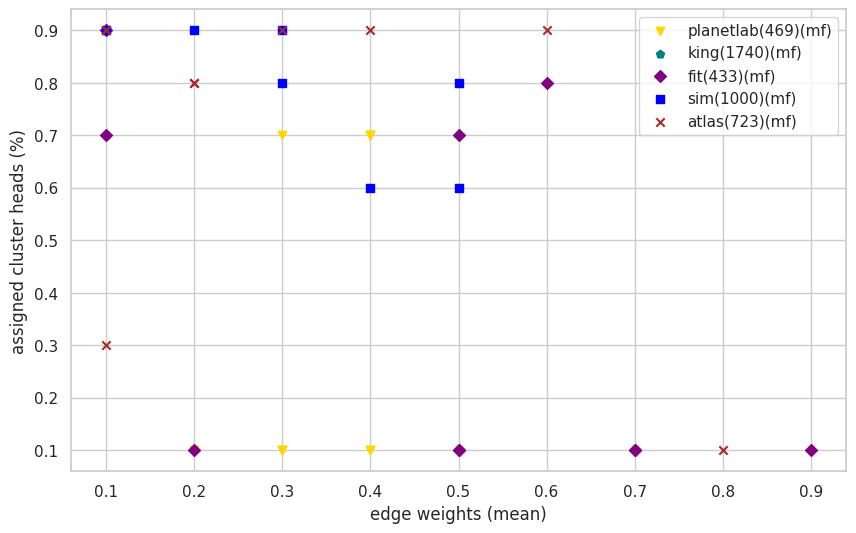

In [164]:
# Specify the figure size (e.g., 8x6 inches)
fig, ax = plt.subplots(figsize=(10, 6))
y_label = "merge_factor"

for k in values_topo.keys():
    data_dict = values_topo[k]
    
    # Extract the keys and values from the dictionary
    x_values = [round(item["mean"], 2) for item in data_dict.values()]
    y_values_mf = [round(item["params"]["latency (90P)"]["merge_factor"], 2) for item in data_dict.values()]
    y_values_ss = [round(item["params"]["latency (90P)"]["step_size"], 2) for item in data_dict.values()]
    
    c = plot_topo[k]["color"]
    m = plot_topo[k]["marker"]
    
    # Create the main plot
    if k != "sim(1000)":
        k = k + "(" + str(df_dict_topologies[k][0].shape[0]) + ")"
    
    ax.scatter(y_values_ss, y_values_mf, marker=m, color=c, label=k + "(mf)")
    # ax.scatter(x_values, y_values_ss, marker="2", color=c, label=k + "(ss)")
    
    # Calculate the regression line
    coefficients = np.polyfit(x_values, y_values_mf, 2)
    regression_line = np.polyval(coefficients, x_values)
    
    # Plot the regression line
    # ax.plot(x_values, regression_line, "--", color=c)

# Set axis labels and title for the main plot
ax.set_xlabel('edge weights (mean)')
ax.set_ylabel('assigned cluster heads (%)')

# ax.set_ylim([-1, 54])

# Create a legend for the scatter plot with a label
legend = ax.legend()
# legend.set_title("Topology")

# Display the plot
plt.show()

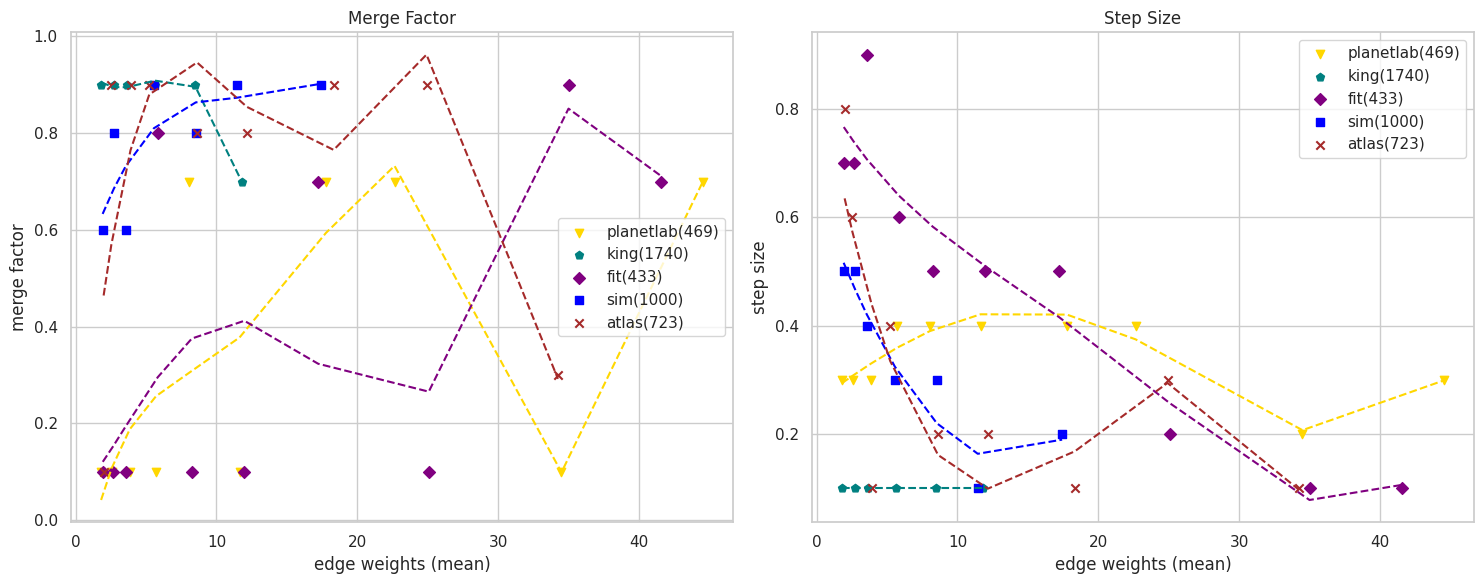

In [165]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))  # Create two subplots side by side

# Subplot 1: merge_factor
ax1.set_title('Merge Factor')
ax1.set_xlabel('edge weights (mean)')
ax1.set_ylabel('merge factor')

# Subplot 2: step_size
ax2.set_title('Step Size')
ax2.set_xlabel('edge weights (mean)')
ax2.set_ylabel('step size')

for k in values_topo.keys():
    data_dict = values_topo[k]

    x_values = [round(item["mean"], 2) for item in data_dict.values()]
    y_values_mf = [round(item["params"]["latency (90P)"]["merge_factor"], 2) for item in data_dict.values()]
    y_values_ss = [round(item["params"]["latency (90P)"]["step_size"], 2) for item in data_dict.values()]

    c = plot_topo[k]["color"]
    m = plot_topo[k]["marker"]

    if k != "sim(1000)":
        k = k + "(" + str(df_dict_topologies[k][0].shape[0]) + ")"

    # Plot data in Subplot 1
    ax1.scatter(x_values, y_values_mf, marker=m, color=c, label=k)
    
    # Calculate the regression line
    coefficients = np.polyfit(x_values, y_values_mf, len(x_values)/2)
    regression_line = np.polyval(coefficients, x_values)
    ax1.plot(x_values, regression_line, "--", color=c)

    # Plot data in Subplot 2
    ax2.scatter(x_values, y_values_ss, marker=m, color=c, label=k)
    
    # Calculate the regression line
    coefficients = np.polyfit(x_values, y_values_ss, len(x_values)/2 - 1)
    regression_line = np.polyval(coefficients, x_values)
    ax2.plot(x_values, regression_line, "--", color=c)

# Display the legend
ax1.legend()
ax2.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Display the subplots
plt.show()

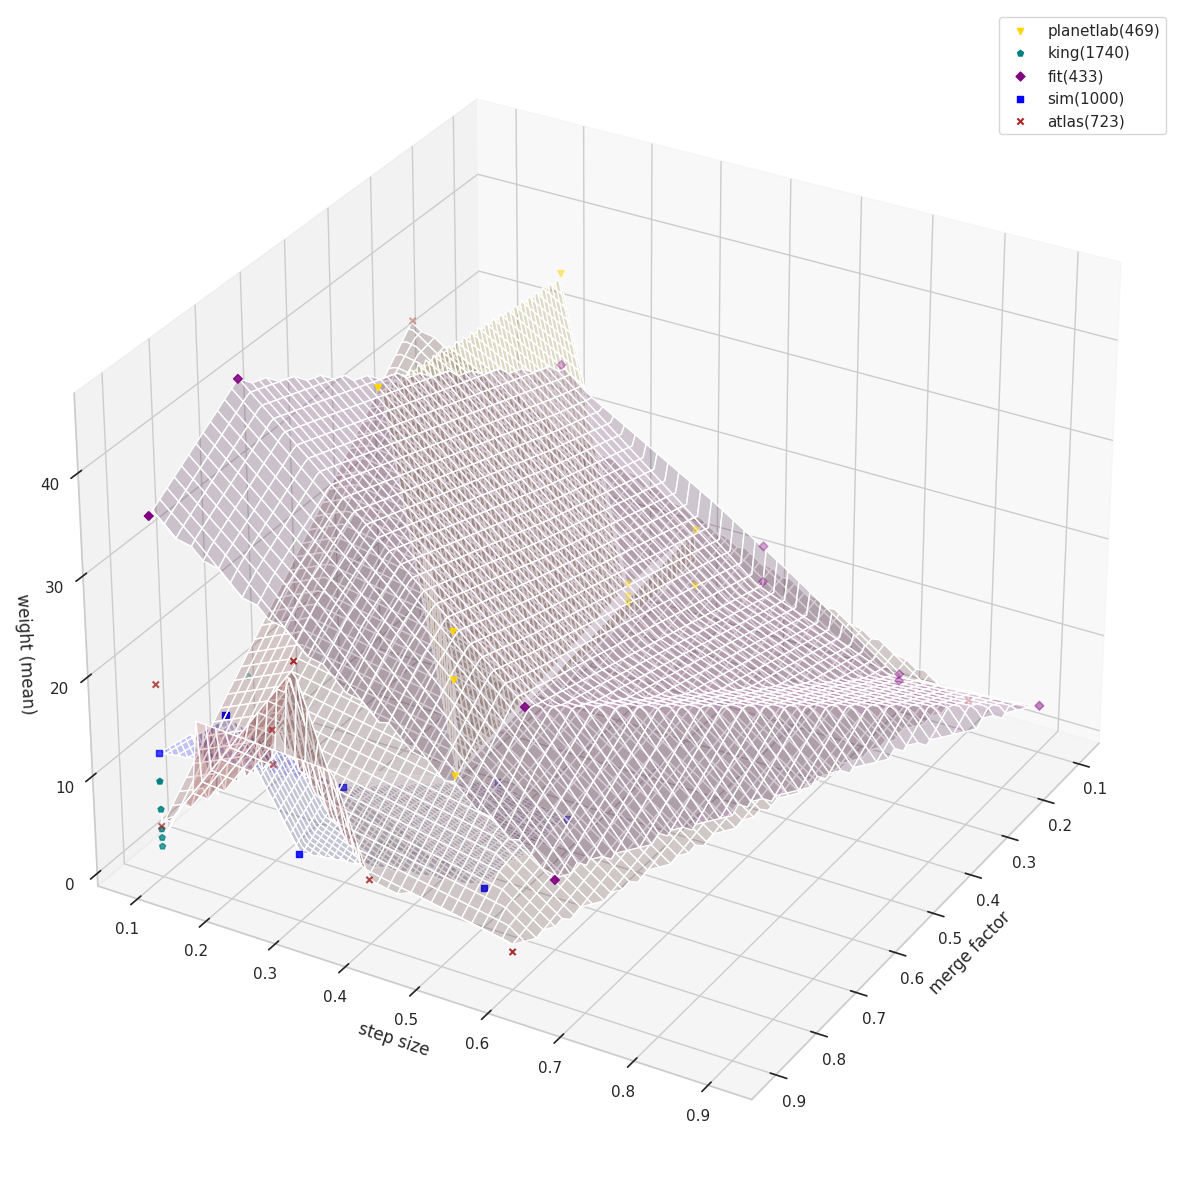

In [166]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from scipy.interpolate import Rbf

fig = plt.figure(figsize=(12, 18))
ax1 = fig.add_subplot(111, projection='3d')

# Subplot 1: merge_factor
ax1.set_xlabel('merge factor')
ax1.set_ylabel('step size')
ax1.set_zlabel("weight (mean)", rotation=90)

for k in values_topo.keys():
    data_dict = values_topo[k]

    x_values = np.array([round(item["mean"], 2) for item in data_dict.values()])
    y_values_mf = np.array([round(item["params"]["latency (90P)"]["merge_factor"], 2) for item in data_dict.values()])
    y_values_ss = np.array([round(item["params"]["latency (90P)"]["step_size"], 2) for item in data_dict.values()])

    c = plot_topo[k]["color"]
    m = plot_topo[k]["marker"]

    if k != "sim(1000)":
        k = k + "(" + str(df_dict_topologies[k][0].shape[0]) + ")"

    # Plot data in Subplot 1
    ax1.scatter(y_values_mf, y_values_ss, x_values, marker=m, color=c, label=k)

    # Create a mesh grid for plotting the surface
    xx, yy = np.meshgrid(np.linspace(min(y_values_mf), max(y_values_mf), 100),
                         np.linspace(min(y_values_ss), max(y_values_ss), 100))
    
    # Joggle the data
    joggle = 0.001
    x_values += np.random.uniform(-joggle, joggle, x_values.shape)
    y_values_mf += np.random.uniform(-joggle, joggle, y_values_mf.shape)
    y_values_ss += np.random.uniform(-joggle, joggle, y_values_ss.shape)
    
    # Interpolate the surface using griddata
    zz = griddata((y_values_mf, y_values_ss), x_values, (xx, yy), method='linear')

    # Plot the interpolated surface
    ax1.plot_surface(xx, yy, zz, color=c, alpha=0.2)

# Automatically set a view angle and elevation
ax1.view_init(azim=30)

# Display the legend
ax1.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Display the subplots
plt.show()
